In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver

from transforms import transforms
from Decon import SpectralDecon


from SignalAttenuation import Attenuation
from SignalAttenuation import AnnualLayerThick

In [3]:
#from DiffLen_UncertaintyEst import Calc_diffLen_RandLT

# Example of perturbation of Laki and Tambora positions


### Define data

In [4]:
site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


### Define Laki and Tambora eruption width

In [5]:
depth_ECM = np.asarray(data_ECM['depth']); ECM = np.asarray(data_ECM['ECM'])
depth_ECM_LT = np.asarray(data_ECM_LT['depth']); ECM_LT = np.asarray(data_ECM_LT['ECM'])

lenTamb = (CoreSpecs['lenTambCor'])/100
lenLaki = (CoreSpecs['lenLakiCor'])/100

startTamb = dTamb_in - lenTamb/2; endTamb = dTamb_in + lenTamb/2
startLaki = dLaki_in - lenLaki/2; endLaki = dLaki_in + lenLaki/2



depth_ECM_Laki = depth_ECM[(depth_ECM >= startLaki) & (depth_ECM <= endLaki)]
ECM_Laki = ECM[(depth_ECM >= startLaki) & (depth_ECM <= endLaki)]

depth_ECM_Tamb = depth_ECM[(depth_ECM >= startTamb) & (depth_ECM <= endTamb)]
ECM_Tamb = ECM[(depth_ECM >= startTamb) & (depth_ECM <= endTamb)]


fitMin = 0.1
fitMax = 0.1
depth_ECM_Tamb_Fit = depth_ECM[(depth_ECM >= startTamb-fitMin) & (depth_ECM <= endTamb+fitMax)]
ECM_Tamb_Fit = ECM[(depth_ECM >= startTamb-fitMin) & (depth_ECM <= endTamb+fitMax)]

depth_ECM_Laki_Fit = depth_ECM[(depth_ECM >= startLaki-fitMin) & (depth_ECM <= endLaki+fitMax)]
ECM_Laki_Fit = ECM[(depth_ECM >= startLaki-fitMin) & (depth_ECM <= endLaki+fitMax)]




depth_Laki = depth[(depth >= startLaki) & (depth <= endLaki)]
d18O_Laki = d18O[(depth >= startLaki) & (depth <= endLaki)]

depth_Tamb = depth[(depth >= startTamb) & (depth <= endTamb)]
d18O_Tamb = d18O[(depth >= startTamb) & (depth <= endTamb)]

### Plot Laki and Tambora eruption width

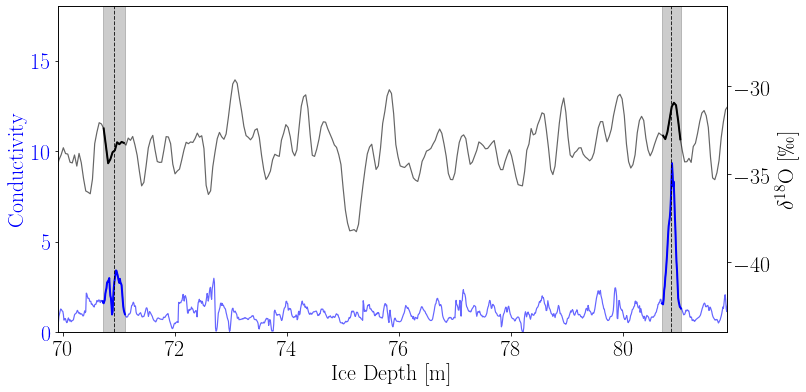

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(depth_ECM,ECM, lw=1.2, color='b', alpha=0.6)
#ax.plot(depth_ECM_LT, ECM_LT)
ax.plot(depth_ECM_Laki,ECM_Laki, lw=2, color='b')
ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')

ax.set(xlim=(dTamb_in-1, dLaki_in+1), ylim=(0,18), xlabel='Ice Depth [m]')
ax.set_ylabel('Conductivity', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=dTamb_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dLaki_in, ls='--', color='k', alpha=0.8, lw=1)

ax.axvspan(startLaki, endLaki, alpha=0.2, color='k')
ax.axvspan(startTamb, endTamb, alpha=0.2, color='k')






ax_2 = ax.twinx()
ax_2.plot(depth, d18O, lw=1.2, color='k', alpha=0.6)
#ax_2.plot(depth_LT, d18O_LT, color='k', lw=1.2)
ax_2.plot(depth_Laki,d18O_Laki, lw=2, color='k')
ax_2.plot(depth_Tamb,d18O_Tamb, lw=2, color='k')

ax_2.set_ylabel('$\delta^{18}$O [$\permil$]', color='k')
ax_2.tick_params(axis='y', labelcolor='k')

In [7]:
def gaussian(x, N, mu, sigma, a):
    return N * 1. / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2) + a

x = depth_ECM_Tamb_Fit
y = gaussian(x, 1, dTamb_in, lenTamb/4, 0.7)

x1 = depth_ECM_Laki_Fit
y1 = gaussian(x1, 1, dLaki_in, lenLaki/5, 0.7)

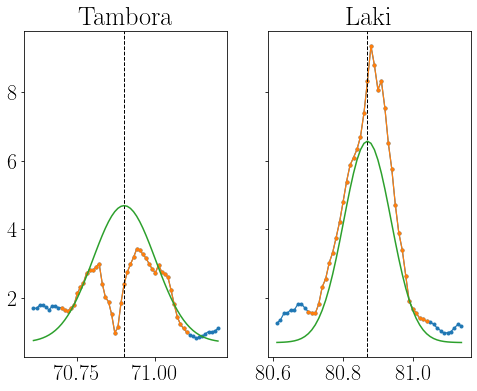

In [8]:
fig, ax = plt.subplots(1,2,figsize=(8,6), sharey=True)

ax[0].plot(depth_ECM_Tamb_Fit,ECM_Tamb_Fit, lw=1.2, marker='.')
ax[0].plot(depth_ECM_Tamb,ECM_Tamb, lw=1.2, marker='.')
ax[0].set(title='Tambora')
ax[0].axvline(x=dTamb_in, lw=1,ls='--',color='k')
ax[0].plot(x,y)

ax[1].plot(depth_ECM_Laki_Fit,ECM_Laki_Fit, lw=1.2, marker='.')
ax[1].plot(depth_ECM_Laki,ECM_Laki, lw=1.2,marker='.')
ax[1].set(title='Laki')
ax[1].axvline(x=dLaki_in, lw=1,ls='--',color='k')
ax[1].plot(x1,y1)
#ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')


### Fit Gaussian to peaks

In [9]:
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import UnbinnedLH, BinnedLH, Chi2Regression, Extended # Helper tool for fitting
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm

In [10]:
from external_functions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [11]:
def func_gaussian(x, N, mu, sigma, a):
    return N * norm.pdf(x, mu, sigma) + a



In [12]:
x = depth_ECM_Laki_Fit
y = ECM_Laki_Fit

In [13]:
chi2_gaussian = Chi2Regression(func_gaussian, x, y)
minuit_gaussian = Minuit(chi2_gaussian, N=1, mu=62.9, sigma=0.25, a = 1)
minuit_gaussian.migrad()

<ipython-input-13-f0933487c807>:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  minuit_gaussian.migrad()


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 341.4                      │              Nfcn = 153              │
│ EDM = 1.52e-15 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │     1     │     0     │            │            │         │         │       │
│ 1 │ mu    │  6.29e1   │  0.00e1   │            │            │         │         │       │
│ 2 │ sigma │  2.5e-1   │  0.0e-1   │            │            │         │         │       │
│ 3 │ a     │  3.3431   │  0.0000   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [14]:
vals = minuit_gaussian.values

Ndof_gau = len(x) - 4
Prob_gau = stats.chi2.sf(minuit_gaussian.fval, Ndof_gau)

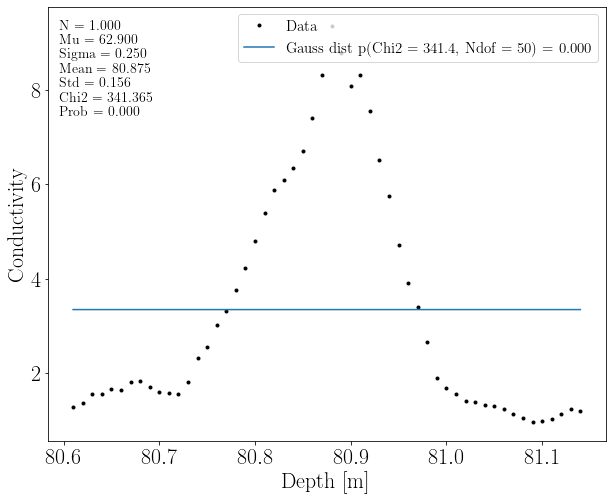

In [15]:
xs = np.linspace(min(x), max(x), 10000)
ys = func_gaussian(xs, vals[0], vals[1], vals[2], vals[3])


fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, y,'.', c='k', label='Data')
ax.set(xlabel='Depth [m]', ylabel='Conductivity')
ax.plot(xs, ys, '-', label = f'Gauss dist p(Chi2 = {minuit_gaussian.fval:.1f}, Ndof = {Ndof_gau:d}) = {Prob_gau:.3f}')

d = {'N = ': minuit_gaussian.values['N'],
     'Mu = ': minuit_gaussian.values['mu'],
     'Sigma = ': minuit_gaussian.values['sigma'],
     'Mean = ': np.mean(x),
     'Std = ': np.std(x),
     'Chi2 = ': minuit_gaussian.fval,
     'Prob = ': Prob_gau,
    }
    
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=14)

ax.legend(fontsize=15)



### Define new random estimate of Laki and Tamb locations

In [16]:
maxTamb = lenTamb/2
maxLaki = lenLaki/2

randTamb = np.random.normal(dTamb_in,lenTamb/4)
randLaki = np.random.normal(dLaki_in,lenLaki/5)

dTamb = randTamb
dLaki = randLaki
print(dTamb)
print(dLaki)

70.87917157285783
80.95775304832617


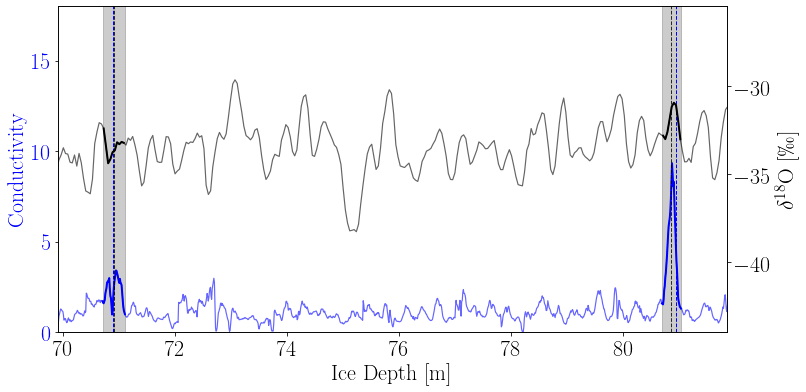

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(depth_ECM,ECM, lw=1.2, color='b', alpha=0.6)
#ax.plot(depth_ECM_LT, ECM_LT)
ax.plot(depth_ECM_Laki,ECM_Laki, lw=2, color='b')
ax.plot(depth_ECM_Tamb,ECM_Tamb, lw=2, color='b')

ax.set(xlim=(dTamb_in-1, dLaki_in+1), ylim=(0,18), xlabel='Ice Depth [m]')
ax.set_ylabel('Conductivity', color='blue')
ax.tick_params(axis='y', labelcolor='blue')

ax.axvline(x=dTamb_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dTamb, ls='--', color='b', lw=1)

ax.axvline(x=dLaki_in, ls='--', color='k', alpha=0.8, lw=1)
ax.axvline(x=dLaki, ls='--', color='b', lw=1)

ax.axvspan(startLaki, endLaki, alpha=0.2, color='k')
ax.axvspan(startTamb, endTamb, alpha=0.2, color='k')






ax_2 = ax.twinx()
ax_2.plot(depth, d18O, lw=1.2, color='k', alpha=0.6)
#ax_2.plot(depth_LT, d18O_LT, color='k', lw=1.2)
ax_2.plot(depth_Laki,d18O_Laki, lw=2, color='k')
ax_2.plot(depth_Tamb,d18O_Tamb, lw=2, color='k')

ax_2.set_ylabel('$\delta^{18}$O [$\permil$]', color='k')
ax_2.tick_params(axis='y', labelcolor='k')

### Define new sets of data in new LT series

In [18]:
DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]
data_ECM = DataAll[2]
data_dens = DataAll[4]
data_diff = DataAll[6]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = depth[(depth >= dTamb) & (depth <= dLaki)]
d18O_LT = d18O[(depth >= dTamb) & (depth <= dLaki)]



depthDiff = data_diff['Depth']
diff = data_diff['sigma_o18']

depthDiff_LT = depthDiff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]
diff_LT = diff[(depthDiff >= dTamb) & (depthDiff <= dLaki)]



depthDens = data_dens['depth']
dens = data_dens['HLmodel']

depthDens_LT = depthDens[(depthDens >= dTamb) & (depthDens <= dLaki)]
dens_LT = dens[(depthDens >= dTamb) & (depthDens <= dLaki)]


In [19]:
data_dens_LT = pd.DataFrame({'depth': depthDens_LT, 'HLmodel': dens_LT})
data_diff_LT = pd.DataFrame({'Depth': depthDiff_LT, 'sigma_o18': diff_LT})

### Test backdiffusion algorithm


In [21]:
dataAll = pd.DataFrame({'depth':depth,'d18O':d18O}, index=None)

inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30)

depthOpt, dataOpt, diffLen, Peaks, Ts, pats = inst.BackDiffused_constraints(LayerThickness=0, N_summers=0, N_winters=0, Amplitude=0, N=2000, print_Npeaks=True, theoDiffLen=True, diffLenStart_In=0, diffLenEnd_In=0.1, interpAfterDecon=True, newDelta=0, interpBFDecon=True)

Sigma fit: 7.18
Min sigma analyt: 7.69
Starting sigma: 5.18 [cm]
Final sigma: 7.37 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038


In [25]:
peaks = Peaks

In [22]:
#dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

#inst = BackDiffuse(site, dataAll, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT, Dist=30)

#depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

In [26]:
from DiffusionProfiles_calculations import sampling_sigma
sampleSize_ave = np.mean(np.diff(depth_LT))
print(f'Average sampling size in interval: {sampleSize_ave:.3f}\n')
sigma_sample = sampling_sigma(sampleSize_ave)
sigma_firn = np.sqrt(diffLen**2 - sigma_sample**2)

print(f'Total diffusion length estimate: \t{diffLen*100:.2f} [cm]')
print(f'Sampling diffusion length estimate: \t{sigma_sample*100:.2f} [cm]')
print(f'Firn diffusion length estimate: \t{sigma_firn*100:.2f} [cm]')


Average sampling size in interval: 0.039

Total diffusion length estimate: 	7.37 [cm]
Sampling diffusion length estimate: 	1.19 [cm]
Firn diffusion length estimate: 	7.28 [cm]


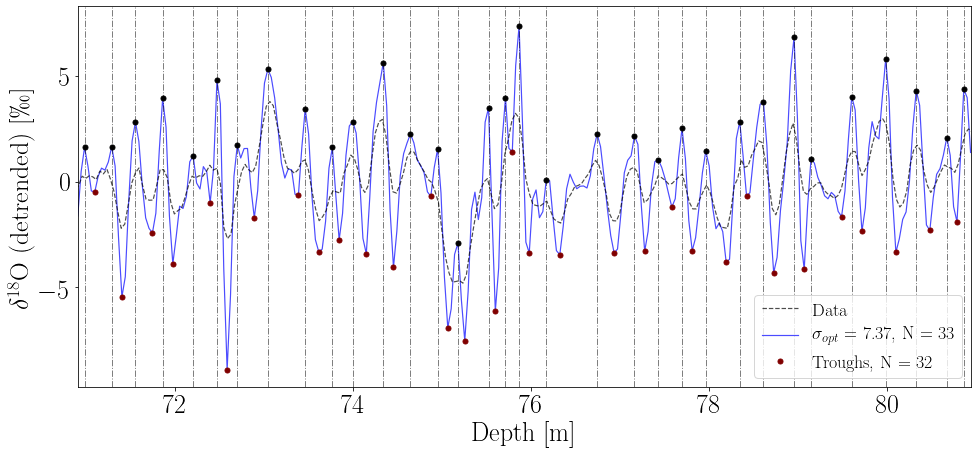

In [28]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)

troughs = sp.signal.find_peaks(-dataOpt)[0]
plt.plot(depthOpt[Ts],dataOpt[Ts], '.',color='maroon',ms=10, label=f'Troughs, N = {len(Ts)}')

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [$\permil$]',xlim=(min(depthOpt),max(depthOpt)))
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='k',zorder=1, s=25)

for i in range(len(peaks)):
    ax.axvline(depthOpt[peaks[i]],lw=1,color='k',ls='-.',alpha=0.5)
#for i in range(len(troughs)):
#    ax.axvline(depthOpt[troughs[i]],lw=1,color='maroon',ls='--', alpha=0.5)

#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')


# Run above code N times

In [9]:
from DiffLen_UncertaintyEst import Calc_diffLen_Gauss

site = 'SiteA'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

N = 100
diffLens = np.zeros(N)
print(N)
for i in range(N):
    print(i)
    diffLens[i] = Calc_diffLen_Gauss('SiteA', 33, CoresSpecs)

np.savetxt('Test.csv', diffLens)



##########SiteA##########

0
Sigma fit: 7.18
Min sigma analyt: 7.69
Starting sigma: 5.18 [cm]
Final sigma: 7.38 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
1
Sigma fit: 6.72
Min sigma analyt: 7.69
Starting sigma: 4.72 [cm]
Final sigma: 7.02 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
2
Sigma fit: 7.00
Min sigma analyt: 7.69
Starting sigma: 5.00 [cm]
Final sigma: 7.47 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
3
Sigma fit: 7.90
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.55 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
4
Sigma fit: 7.53
Min sigma analyt: 7.69
Starting sigma: 5.53 [cm]
Final sigma: 7.77 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
5
Sigma fit: 7.58
Min sigma analyt: 7.69
Starting sigma: 5.58 [cm]
Final sigma: 8.17 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
6
Sigma fit: 6.99
Min sigma analyt: 7.70
Starting sigma: 4.99 [cm]
Final sigma: 7.15 [cm]
Final # of peaks: 33
Delta: 0.038
De

Sigma fit: 7.12
Min sigma analyt: 7.70
Starting sigma: 5.12 [cm]
Final sigma: 7.44 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
59
Sigma fit: 7.42
Min sigma analyt: 7.69
Starting sigma: 5.42 [cm]
Final sigma: 8.13 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
60
Sigma fit: 6.89
Min sigma analyt: 7.70
Starting sigma: 4.89 [cm]
Final sigma: 7.17 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
61
Sigma fit: 7.21
Min sigma analyt: 7.70
Starting sigma: 5.21 [cm]
Final sigma: 7.33 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
62
Sigma fit: 6.76
Min sigma analyt: 7.69
Starting sigma: 4.76 [cm]
Final sigma: 7.08 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
63
Sigma fit: 6.64
Min sigma analyt: 7.70
Starting sigma: 4.64 [cm]
Final sigma: 6.64 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
64
Sigma fit: 6.83
Min sigma analyt: 7.69
Starting sigma: 4.83 [cm]
Final sigma: 6.66 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
65
Sigma 

Sigma fit: 7.02
Min sigma analyt: 7.70
Starting sigma: 5.02 [cm]
Final sigma: 7.41 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
117
Sigma fit: 7.71
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.39 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
118
Sigma fit: 7.70
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.34 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
119
Sigma fit: 7.35
Min sigma analyt: 7.69
Starting sigma: 5.35 [cm]
Final sigma: 7.70 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
120
Sigma fit: 7.71
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.39 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
121
Sigma fit: 7.68
Min sigma analyt: 7.69
Starting sigma: 5.68 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
122
Sigma fit: 6.66
Min sigma analyt: 7.69
Starting sigma: 4.66 [cm]
Final sigma: 6.83 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
123

Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
174
Sigma fit: 7.15
Min sigma analyt: 7.69
Starting sigma: 5.15 [cm]
Final sigma: 7.39 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
175
Sigma fit: 7.72
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.42 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
176
Sigma fit: 6.73
Min sigma analyt: 7.70
Starting sigma: 4.73 [cm]
Final sigma: 6.63 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
177
Sigma fit: 7.22
Min sigma analyt: 7.70
Starting sigma: 5.22 [cm]
Final sigma: 7.40 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
178
Sigma fit: 7.17
Min sigma analyt: 7.69
Starting sigma: 5.17 [cm]
Final sigma: 7.35 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
179
Sigma fit: 7.42
Min sigma analyt: 7.69
Starting sigma: 5.42 [cm]
Final sigma: 8.13 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
180
Sigma fit: 6.72
Min sigma analyt: 7.69
Starting sigma: 4.72 [cm]

Sigma fit: 7.33
Min sigma analyt: 7.70
Starting sigma: 5.33 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
232
Sigma fit: 7.33
Min sigma analyt: 7.70
Starting sigma: 5.33 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
233
Sigma fit: 7.11
Min sigma analyt: 7.69
Starting sigma: 5.11 [cm]
Final sigma: 8.05 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
234
Sigma fit: 6.76
Min sigma analyt: 7.69
Starting sigma: 4.76 [cm]
Final sigma: 7.01 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
235
Sigma fit: 7.59
Min sigma analyt: 7.69
Starting sigma: 5.59 [cm]
Final sigma: 8.16 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
236
Sigma fit: 7.45
Min sigma analyt: 7.69
Starting sigma: 5.45 [cm]
Final sigma: 8.18 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
237
Sigma fit: 7.22
Min sigma analyt: 7.70
Starting sigma: 5.22 [cm]
Final sigma: 7.40 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
238

Final sigma: 7.94 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
289
Sigma fit: 6.66
Min sigma analyt: 7.69
Starting sigma: 4.66 [cm]
Final sigma: 6.83 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
290
Sigma fit: 7.62
Min sigma analyt: 7.69
Starting sigma: 5.62 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
291
Sigma fit: 7.62
Min sigma analyt: 7.69
Starting sigma: 5.62 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
292
Sigma fit: 7.07
Min sigma analyt: 7.69
Starting sigma: 5.07 [cm]
Final sigma: 7.38 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
293
Sigma fit: 6.52
Min sigma analyt: 7.70
Starting sigma: 4.52 [cm]
Final sigma: 6.48 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
294
Sigma fit: 7.18
Min sigma analyt: 7.70
Starting sigma: 5.18 [cm]
Final sigma: 7.33 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
295
Sigma fit: 7.72
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]

Sigma fit: 8.18
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.79 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
347
Sigma fit: 7.30
Min sigma analyt: 7.69
Starting sigma: 5.30 [cm]
Final sigma: 7.78 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
348
Sigma fit: 7.05
Min sigma analyt: 7.70
Starting sigma: 5.05 [cm]
Final sigma: 6.98 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
349
Sigma fit: 7.33
Min sigma analyt: 7.70
Starting sigma: 5.33 [cm]
Final sigma: 7.59 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
350
Sigma fit: 6.85
Min sigma analyt: 7.69
Starting sigma: 4.85 [cm]
Final sigma: 7.36 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
351
Sigma fit: 6.97
Min sigma analyt: 7.69
Starting sigma: 4.97 [cm]
Final sigma: 6.89 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
352
Sigma fit: 6.49
Min sigma analyt: 7.70
Starting sigma: 4.49 [cm]
Final sigma: 6.23 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
353

Final sigma: 7.77 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
404
Sigma fit: 7.08
Min sigma analyt: 7.70
Starting sigma: 5.08 [cm]
Final sigma: 7.05 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
405
Sigma fit: 7.49
Min sigma analyt: 7.69
Starting sigma: 5.49 [cm]
Final sigma: 8.17 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
406
Sigma fit: 7.41
Min sigma analyt: 7.69
Starting sigma: 5.41 [cm]
Final sigma: 8.12 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
407
Sigma fit: 7.18
Min sigma analyt: 7.69
Starting sigma: 5.18 [cm]
Final sigma: 7.38 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
408
Sigma fit: 6.61
Min sigma analyt: 7.70
Starting sigma: 4.61 [cm]
Final sigma: 6.61 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
409
Sigma fit: 7.49
Min sigma analyt: 7.69
Starting sigma: 5.49 [cm]
Final sigma: 8.15 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
410
Sigma fit: 7.72
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]

Sigma fit: 7.33
Min sigma analyt: 7.69
Starting sigma: 5.33 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
462
Sigma fit: 7.70
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.34 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
463
Sigma fit: 7.01
Min sigma analyt: 7.69
Starting sigma: 5.01 [cm]
Final sigma: 7.50 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
464
Sigma fit: 7.71
Min sigma analyt: 7.69
Starting sigma: 5.69 [cm]
Final sigma: 8.39 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
465
Sigma fit: 7.49
Min sigma analyt: 7.69
Starting sigma: 5.49 [cm]
Final sigma: 8.17 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
466
Sigma fit: 7.17
Min sigma analyt: 7.69
Starting sigma: 5.17 [cm]
Final sigma: 7.35 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
467
Sigma fit: 7.17
Min sigma analyt: 7.69
Starting sigma: 5.17 [cm]
Final sigma: 7.36 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
468

Final sigma: 7.33 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
19
Sigma fit: 7.32
Min sigma analyt: 7.58
Starting sigma: 5.32 [cm]
Final sigma: 7.72 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
20
Sigma fit: 7.14
Min sigma analyt: 7.58
Starting sigma: 5.14 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
21
Sigma fit: 7.46
Min sigma analyt: 7.58
Starting sigma: 5.46 [cm]
Final sigma: 6.00 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
22
Sigma fit: 7.21
Min sigma analyt: 7.58
Starting sigma: 5.21 [cm]
Final sigma: 7.65 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
23
Sigma fit: 6.92
Min sigma analyt: 7.58
Starting sigma: 4.92 [cm]
Final sigma: 7.40 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
24
Sigma fit: 7.52
Min sigma analyt: 7.58
Starting sigma: 5.52 [cm]
Final sigma: 5.59 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
25
Sigma fit: 7.85
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final 

Final sigma: 7.67 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
77
Sigma fit: 7.10
Min sigma analyt: 7.58
Starting sigma: 5.10 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
78
Sigma fit: 7.00
Min sigma analyt: 7.58
Starting sigma: 5.00 [cm]
Final sigma: 7.45 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
79
Sigma fit: 7.08
Min sigma analyt: 7.58
Starting sigma: 5.08 [cm]
Final sigma: 7.25 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
80
Sigma fit: 7.20
Min sigma analyt: 7.58
Starting sigma: 5.20 [cm]
Final sigma: 7.63 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
81
Sigma fit: 7.20
Min sigma analyt: 7.58
Starting sigma: 5.20 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
82
Sigma fit: 7.10
Min sigma analyt: 7.58
Starting sigma: 5.10 [cm]
Final sigma: 7.55 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
83
Sigma fit: 6.97
Min sigma analyt: 7.58
Starting sigma: 4.97 [cm]
Final 

Sigma fit: 7.23
Min sigma analyt: 7.58
Starting sigma: 5.23 [cm]
Final sigma: 7.48 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
135
Sigma fit: 7.16
Min sigma analyt: 7.58
Starting sigma: 5.16 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
136
Sigma fit: 7.34
Min sigma analyt: 7.58
Starting sigma: 5.34 [cm]
Final sigma: 7.50 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
137
Sigma fit: 7.67
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 6.91 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
138
Sigma fit: 7.42
Min sigma analyt: 7.58
Starting sigma: 5.42 [cm]
Final sigma: 5.68 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
139
Sigma fit: 7.22
Min sigma analyt: 7.58
Starting sigma: 5.22 [cm]
Final sigma: 7.64 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
140
Sigma fit: 7.22
Min sigma analyt: 7.58
Starting sigma: 5.22 [cm]
Final sigma: 7.64 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
141

Final sigma: 7.63 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
192
Sigma fit: 7.10
Min sigma analyt: 7.58
Starting sigma: 5.10 [cm]
Final sigma: 7.49 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
193
Sigma fit: 7.41
Min sigma analyt: 7.58
Starting sigma: 5.41 [cm]
Final sigma: 6.03 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
194
Sigma fit: 7.16
Min sigma analyt: 7.58
Starting sigma: 5.16 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
195
Sigma fit: 7.41
Min sigma analyt: 7.58
Starting sigma: 5.41 [cm]
Final sigma: 7.94 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
196
Sigma fit: 7.40
Min sigma analyt: 7.58
Starting sigma: 5.40 [cm]
Final sigma: 7.46 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
197
Sigma fit: 7.20
Min sigma analyt: 7.58
Starting sigma: 5.20 [cm]
Final sigma: 7.63 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
198
Sigma fit: 7.72
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]

Sigma fit: 7.52
Min sigma analyt: 7.58
Starting sigma: 5.52 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
250
Sigma fit: 7.56
Min sigma analyt: 7.58
Starting sigma: 5.56 [cm]
Final sigma: 7.66 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
251
Sigma fit: 7.43
Min sigma analyt: 7.58
Starting sigma: 5.43 [cm]
Final sigma: 6.84 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
252
Sigma fit: 7.77
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.76 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
253
Sigma fit: 7.29
Min sigma analyt: 7.58
Starting sigma: 5.29 [cm]
Final sigma: 7.57 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
254
Sigma fit: 7.29
Min sigma analyt: 7.58
Starting sigma: 5.29 [cm]
Final sigma: 7.87 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
255
Sigma fit: 7.29
Min sigma analyt: 7.58
Starting sigma: 5.29 [cm]
Final sigma: 7.87 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
256

Final sigma: 7.81 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
307
Sigma fit: 7.46
Min sigma analyt: 7.58
Starting sigma: 5.46 [cm]
Final sigma: 6.80 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
308
Sigma fit: 7.67
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 6.92 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
309
Sigma fit: 7.19
Min sigma analyt: 7.58
Starting sigma: 5.19 [cm]
Final sigma: 7.80 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
310
Sigma fit: 7.43
Min sigma analyt: 7.58
Starting sigma: 5.43 [cm]
Final sigma: 6.67 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
311
Sigma fit: 7.20
Min sigma analyt: 7.58
Starting sigma: 5.20 [cm]
Final sigma: 7.18 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
312
Sigma fit: 7.27
Min sigma analyt: 7.58
Starting sigma: 5.27 [cm]
Final sigma: 7.91 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
313
Sigma fit: 8.08
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]

Sigma fit: 7.21
Min sigma analyt: 7.58
Starting sigma: 5.21 [cm]
Final sigma: 7.72 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
365
Sigma fit: 7.27
Min sigma analyt: 7.58
Starting sigma: 5.27 [cm]
Final sigma: 7.80 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
366
Sigma fit: 7.53
Min sigma analyt: 7.58
Starting sigma: 5.53 [cm]
Final sigma: 7.48 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
367
Sigma fit: 7.85
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 8.19 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
368
Sigma fit: 7.85
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 8.19 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
369
Sigma fit: 7.40
Min sigma analyt: 7.58
Starting sigma: 5.40 [cm]
Final sigma: 7.46 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
370
Sigma fit: 7.14
Min sigma analyt: 7.58
Starting sigma: 5.14 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
371

Final sigma: 7.56 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
422
Sigma fit: 7.67
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.02 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
423
Sigma fit: 6.92
Min sigma analyt: 7.58
Starting sigma: 4.92 [cm]
Final sigma: 7.40 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
424
Sigma fit: 7.54
Min sigma analyt: 7.58
Starting sigma: 5.54 [cm]
Final sigma: 7.43 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
425
Sigma fit: 7.21
Min sigma analyt: 7.58
Starting sigma: 5.21 [cm]
Final sigma: 7.34 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
426
Sigma fit: 7.21
Min sigma analyt: 7.58
Starting sigma: 5.21 [cm]
Final sigma: 7.61 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
427
Sigma fit: 7.56
Min sigma analyt: 7.58
Starting sigma: 5.56 [cm]
Final sigma: 5.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
428
Sigma fit: 7.10
Min sigma analyt: 7.58
Starting sigma: 5.10 [cm]

Sigma fit: 7.44
Min sigma analyt: 7.58
Starting sigma: 5.44 [cm]
Final sigma: 6.65 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
480
Sigma fit: 7.47
Min sigma analyt: 7.58
Starting sigma: 5.47 [cm]
Final sigma: 6.82 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
481
Sigma fit: 7.20
Min sigma analyt: 7.58
Starting sigma: 5.20 [cm]
Final sigma: 7.31 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
482
Sigma fit: 7.77
Min sigma analyt: 7.58
Starting sigma: 5.58 [cm]
Final sigma: 7.06 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
483
Sigma fit: 7.22
Min sigma analyt: 7.58
Starting sigma: 5.22 [cm]
Final sigma: 7.64 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
484
Sigma fit: 7.19
Min sigma analyt: 7.58
Starting sigma: 5.19 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
485
Sigma fit: 7.50
Min sigma analyt: 7.58
Starting sigma: 5.50 [cm]
Final sigma: 5.92 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.038
486

Final sigma: 7.00 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
37
Sigma fit: 7.46
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.44 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
38
Sigma fit: 7.74
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 8.08 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
39
Sigma fit: 7.77
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.35 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
40
Sigma fit: 7.69
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.91 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
41
Sigma fit: 7.67
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.42 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
42
Sigma fit: 7.41
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.20 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
43
Sigma fit: 7.77
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final 

Final sigma: 7.32 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
95
Sigma fit: 7.78
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.33 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
96
Sigma fit: 7.84
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.44 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
97
Sigma fit: 7.09
Min sigma analyt: 7.36
Starting sigma: 5.09 [cm]
Final sigma: 7.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
98
Sigma fit: 7.98
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 6.32 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
99
Sigma fit: 7.59
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.87 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
100
Sigma fit: 7.85
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.58 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
101
Sigma fit: 7.23
Min sigma analyt: 7.36
Starting sigma: 5.23 [cm]
Fina

Sigma fit: 7.38
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 6.97 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
153
Sigma fit: 7.12
Min sigma analyt: 7.36
Starting sigma: 5.12 [cm]
Final sigma: 7.09 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
154
Sigma fit: 7.35
Min sigma analyt: 7.36
Starting sigma: 5.35 [cm]
Final sigma: 6.87 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
155
Sigma fit: 7.70
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.26 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
156
Sigma fit: 7.23
Min sigma analyt: 7.36
Starting sigma: 5.23 [cm]
Final sigma: 7.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
157
Sigma fit: 7.09
Min sigma analyt: 7.36
Starting sigma: 5.09 [cm]
Final sigma: 7.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
158
Sigma fit: 7.38
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 6.99 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
159

Final sigma: 8.08 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
210
Sigma fit: 7.40
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.27 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
211
Sigma fit: 7.91
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.50 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
212
Sigma fit: 7.63
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.42 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
213
Sigma fit: 7.86
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.60 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
214
Sigma fit: 7.09
Min sigma analyt: 7.36
Starting sigma: 5.09 [cm]
Final sigma: 7.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
215
Sigma fit: 7.13
Min sigma analyt: 7.36
Starting sigma: 5.13 [cm]
Final sigma: 7.09 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
216
Sigma fit: 7.13
Min sigma analyt: 7.36
Starting sigma: 5.13 [cm]

Sigma fit: 7.67
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.25 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
268
Sigma fit: 7.44
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 6.05 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
269
Sigma fit: 7.38
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.25 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
270
Sigma fit: 7.98
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 8.36 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
271
Sigma fit: 7.34
Min sigma analyt: 7.36
Starting sigma: 5.34 [cm]
Final sigma: 6.88 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
272
Sigma fit: 7.13
Min sigma analyt: 7.36
Starting sigma: 5.13 [cm]
Final sigma: 7.01 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
273
Sigma fit: 7.79
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.74 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
274

Final sigma: 7.50 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
325
Sigma fit: 7.61
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 8.05 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
326
Sigma fit: 7.13
Min sigma analyt: 7.36
Starting sigma: 5.13 [cm]
Final sigma: 7.09 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
327
Sigma fit: 7.88
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.62 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
328
Sigma fit: 7.70
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.26 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
329
Sigma fit: 7.61
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 8.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
330
Sigma fit: 7.23
Min sigma analyt: 7.36
Starting sigma: 5.23 [cm]
Final sigma: 7.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
331
Sigma fit: 7.64
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]

Sigma fit: 7.04
Min sigma analyt: 7.36
Starting sigma: 5.04 [cm]
Final sigma: 5.88 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
383
Sigma fit: 7.61
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.47 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
384
Sigma fit: 7.76
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 8.09 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
385
Sigma fit: 7.75
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.36 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
386
Sigma fit: 7.31
Min sigma analyt: 7.36
Starting sigma: 5.31 [cm]
Final sigma: 6.93 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
387
Sigma fit: 7.75
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.36 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
388
Sigma fit: 7.67
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.40 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
389

Final sigma: 8.07 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
440
Sigma fit: 7.40
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.27 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
441
Sigma fit: 7.07
Min sigma analyt: 7.36
Starting sigma: 5.07 [cm]
Final sigma: 7.01 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
442
Sigma fit: 7.46
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.44 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
443
Sigma fit: 7.38
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 6.99 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
444
Sigma fit: 7.85
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.58 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
445
Sigma fit: 7.38
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.25 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
446
Sigma fit: 7.73
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]

Sigma fit: 7.77
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.35 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
498
Sigma fit: 7.41
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.57 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037
499
Sigma fit: 7.73
Min sigma analyt: 7.36
Starting sigma: 5.36 [cm]
Final sigma: 7.42 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.037

##########SiteE##########

0
Sigma fit: 8.34
Min sigma analyt: 8.85
Starting sigma: 6.34 [cm]
Final sigma: 8.54 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
1
Sigma fit: 7.75
Min sigma analyt: 8.85
Starting sigma: 5.75 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
2
Sigma fit: 7.90
Min sigma analyt: 8.85
Starting sigma: 5.90 [cm]
Final sigma: 8.71 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
3
Sigma fit: 8.04
Min sigma analyt: 8.85
Starting sigma: 6.04 [cm]
Final sigma: 8.84 [cm]
Final # of peaks: 33
Delta: 0.041


Sigma fit: 8.34
Min sigma analyt: 8.85
Starting sigma: 6.34 [cm]
Final sigma: 8.54 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
56
Sigma fit: 7.49
Min sigma analyt: 8.85
Starting sigma: 5.49 [cm]
Final sigma: 8.10 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
57
Sigma fit: 7.42
Min sigma analyt: 8.85
Starting sigma: 5.42 [cm]
Final sigma: 7.89 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
58
Sigma fit: 7.89
Min sigma analyt: 8.85
Starting sigma: 5.89 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
59
Sigma fit: 7.89
Min sigma analyt: 8.85
Starting sigma: 5.89 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
60
Sigma fit: 8.06
Min sigma analyt: 8.85
Starting sigma: 6.06 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
61
Sigma fit: 7.89
Min sigma analyt: 8.85
Starting sigma: 5.89 [cm]
Final sigma: 8.47 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
62
Sigma 

Sigma fit: 7.64
Min sigma analyt: 8.85
Starting sigma: 5.64 [cm]
Final sigma: 8.11 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
114
Sigma fit: 7.54
Min sigma analyt: 8.85
Starting sigma: 5.54 [cm]
Final sigma: 7.71 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
115
Sigma fit: 8.06
Min sigma analyt: 8.85
Starting sigma: 6.06 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
116
Sigma fit: 7.91
Min sigma analyt: 8.85
Starting sigma: 5.91 [cm]
Final sigma: 8.29 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
117
Sigma fit: 7.82
Min sigma analyt: 8.85
Starting sigma: 5.82 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
118
Sigma fit: 7.79
Min sigma analyt: 8.85
Starting sigma: 5.79 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
119
Sigma fit: 7.65
Min sigma analyt: 8.85
Starting sigma: 5.65 [cm]
Final sigma: 8.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
120

Final sigma: 8.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
171
Sigma fit: 7.90
Min sigma analyt: 8.85
Starting sigma: 5.90 [cm]
Final sigma: 8.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
172
Sigma fit: 8.14
Min sigma analyt: 8.85
Starting sigma: 6.14 [cm]
Final sigma: 8.24 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
173
Sigma fit: 7.79
Min sigma analyt: 8.85
Starting sigma: 5.79 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
174
Sigma fit: 8.09
Min sigma analyt: 8.85
Starting sigma: 6.09 [cm]
Final sigma: 8.25 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
175
Sigma fit: 7.82
Min sigma analyt: 8.85
Starting sigma: 5.82 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
176
Sigma fit: 7.97
Min sigma analyt: 8.85
Starting sigma: 5.97 [cm]
Final sigma: 8.36 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
177
Sigma fit: 7.92
Min sigma analyt: 8.85
Starting sigma: 5.92 [cm]

Sigma fit: 7.79
Min sigma analyt: 8.85
Starting sigma: 5.79 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
229
Sigma fit: 7.64
Min sigma analyt: 8.85
Starting sigma: 5.64 [cm]
Final sigma: 8.17 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
230
Sigma fit: 7.84
Min sigma analyt: 8.85
Starting sigma: 5.84 [cm]
Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
231
Sigma fit: 7.66
Min sigma analyt: 8.85
Starting sigma: 5.66 [cm]
Final sigma: 8.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
232
Sigma fit: 7.86
Min sigma analyt: 8.85
Starting sigma: 5.86 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
233
Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
Final sigma: 8.26 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
234
Sigma fit: 7.89
Min sigma analyt: 8.85
Starting sigma: 5.89 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
235

Final sigma: 8.28 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
286
Sigma fit: 7.91
Min sigma analyt: 8.85
Starting sigma: 5.91 [cm]
Final sigma: 8.47 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
287
Sigma fit: 7.81
Min sigma analyt: 8.85
Starting sigma: 5.81 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
288
Sigma fit: 8.25
Min sigma analyt: 8.85
Starting sigma: 6.25 [cm]
Final sigma: 8.81 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
289
Sigma fit: 8.06
Min sigma analyt: 8.85
Starting sigma: 6.06 [cm]
Final sigma: 8.80 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
290
Sigma fit: 7.75
Min sigma analyt: 8.85
Starting sigma: 5.75 [cm]
Final sigma: 8.33 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
291
Sigma fit: 7.85
Min sigma analyt: 8.85
Starting sigma: 5.85 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
292
Sigma fit: 7.62
Min sigma analyt: 8.85
Starting sigma: 5.62 [cm]

Sigma fit: 7.82
Min sigma analyt: 8.85
Starting sigma: 5.82 [cm]
Final sigma: 8.29 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
344
Sigma fit: 7.94
Min sigma analyt: 8.85
Starting sigma: 5.94 [cm]
Final sigma: 8.34 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
345
Sigma fit: 7.95
Min sigma analyt: 8.85
Starting sigma: 5.95 [cm]
Final sigma: 8.28 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
346
Sigma fit: 8.05
Min sigma analyt: 8.85
Starting sigma: 6.05 [cm]
Final sigma: 8.33 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
347
Sigma fit: 7.79
Min sigma analyt: 8.85
Starting sigma: 5.79 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
348
Sigma fit: 7.61
Min sigma analyt: 8.85
Starting sigma: 5.61 [cm]
Final sigma: 8.30 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
349
Sigma fit: 7.77
Min sigma analyt: 8.85
Starting sigma: 5.77 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
350

Final sigma: 8.43 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
401
Sigma fit: 8.09
Min sigma analyt: 8.85
Starting sigma: 6.09 [cm]
Final sigma: 8.25 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
402
Sigma fit: 7.61
Min sigma analyt: 8.85
Starting sigma: 5.61 [cm]
Final sigma: 8.17 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
403
Sigma fit: 7.89
Min sigma analyt: 8.85
Starting sigma: 5.89 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
404
Sigma fit: 7.94
Min sigma analyt: 8.85
Starting sigma: 5.94 [cm]
Final sigma: 8.66 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
405
Sigma fit: 7.84
Min sigma analyt: 8.85
Starting sigma: 5.84 [cm]
Final sigma: 8.42 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
406
Sigma fit: 7.98
Min sigma analyt: 8.85
Starting sigma: 5.98 [cm]
Final sigma: 7.73 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
407
Sigma fit: 7.61
Min sigma analyt: 8.85
Starting sigma: 5.61 [cm]

Sigma fit: 7.90
Min sigma analyt: 8.85
Starting sigma: 5.90 [cm]
Final sigma: 8.29 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
459
Sigma fit: 7.92
Min sigma analyt: 8.85
Starting sigma: 5.92 [cm]
Final sigma: 8.25 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
460
Sigma fit: 7.96
Min sigma analyt: 8.85
Starting sigma: 5.96 [cm]
Final sigma: 8.39 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
461
Sigma fit: 7.49
Min sigma analyt: 8.85
Starting sigma: 5.49 [cm]
Final sigma: 8.13 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
462
Sigma fit: 7.93
Min sigma analyt: 8.85
Starting sigma: 5.93 [cm]
Final sigma: 8.37 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
463
Sigma fit: 7.69
Min sigma analyt: 8.85
Starting sigma: 5.69 [cm]
Final sigma: 7.97 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
464
Sigma fit: 8.06
Min sigma analyt: 8.85
Starting sigma: 6.06 [cm]
Final sigma: 8.27 [cm]
Final # of peaks: 33
Delta: 0.041
Delta new: 0.041
465

Final sigma: 8.48 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
16
Sigma fit: 7.84
Min sigma analyt: 8.85
Starting sigma: 5.84 [cm]
Final sigma: 8.89 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
17
Sigma fit: 8.13
Min sigma analyt: 8.85
Starting sigma: 6.13 [cm]
Final sigma: 9.44 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
18
Sigma fit: 8.12
Min sigma analyt: 8.85
Starting sigma: 6.12 [cm]
Final sigma: 9.49 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
19
Sigma fit: 7.82
Min sigma analyt: 8.85
Starting sigma: 5.82 [cm]
Final sigma: 9.14 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
20
Sigma fit: 7.85
Min sigma analyt: 8.85
Starting sigma: 5.85 [cm]
Final sigma: 8.91 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
21
Sigma fit: 8.35
Min sigma analyt: 8.85
Starting sigma: 6.35 [cm]
Final sigma: 9.71 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
22


/home/thea/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thea/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Sigma fit: 8.71
Min sigma analyt: 8.85
Starting sigma: 6.71 [cm]
Final sigma: 11.13 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
23
Sigma fit: 7.88
Min sigma analyt: 8.85
Starting sigma: 5.88 [cm]
Final sigma: 9.20 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
24
Sigma fit: 8.61
Min sigma analyt: 8.85
Starting sigma: 6.61 [cm]
Final sigma: 10.46 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
25
Sigma fit: 8.63
Min sigma analyt: 8.85
Starting sigma: 6.63 [cm]
Final sigma: 10.09 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
26
Sigma fit: 7.92
Min sigma analyt: 8.85
Starting sigma: 5.92 [cm]
Final sigma: 9.31 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
27
Sigma fit: 8.38
Min sigma analyt: 8.87
Starting sigma: 6.38 [cm]
Final sigma: 9.90 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
28
Sigma fit: 7.76
Min sigma analyt: 8.85
Starting sigma: 5.76 [cm]
Final sigma: 9.01 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
29
Sig

Sigma fit: 8.66
Min sigma analyt: 8.85
Starting sigma: 6.66 [cm]
Final sigma: 10.43 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
81
Sigma fit: 8.03
Min sigma analyt: 8.85
Starting sigma: 6.03 [cm]
Final sigma: 8.76 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
82
Sigma fit: 7.93
Min sigma analyt: 8.87
Starting sigma: 5.93 [cm]
Final sigma: 8.96 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
83
Sigma fit: 8.08
Min sigma analyt: 8.85
Starting sigma: 6.08 [cm]
Final sigma: 9.62 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
84
Sigma fit: 7.78
Min sigma analyt: 8.85
Starting sigma: 5.78 [cm]
Final sigma: 8.62 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
85
Sigma fit: 8.63
Min sigma analyt: 8.87
Starting sigma: 6.63 [cm]
Final sigma: 10.09 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
86
Sigma fit: 8.29
Min sigma analyt: 8.85
Starting sigma: 6.29 [cm]
Final sigma: 9.94 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
87
Sigm

/home/thea/Documents/KUFysik/MesterTesen/Analysis/Decon.py:350: RuntimeWarning: divide by zero encountered in log10
  res = weights*(np.log10(y) - np.log10(np.copy(Pmod)))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Sigma fit: 1.00
Min sigma analyt: 8.85
Starting sigma: -1.00 [cm]
Final sigma: -7.00 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
126
Sigma fit: 8.07
Min sigma analyt: 8.85
Starting sigma: 6.07 [cm]
Final sigma: 8.78 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
127
Sigma fit: 7.91
Min sigma analyt: 8.85
Starting sigma: 5.91 [cm]
Final sigma: 9.46 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
128
Sigma fit: 8.55
Min sigma analyt: 8.85
Starting sigma: 6.55 [cm]
Final sigma: 10.56 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
129
Sigma fit: 7.65
Min sigma analyt: 8.85
Starting sigma: 5.65 [cm]
Final sigma: 8.63 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
130
Sigma fit: 8.21
Min sigma analyt: 8.85
Starting sigma: 6.21 [cm]
Final sigma: 9.56 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
131
Sigma fit: 8.18
Min sigma analyt: 8.85
Starting sigma: 6.18 [cm]
Final sigma: 9.72 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040


Final sigma: 9.68 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
183
Sigma fit: 7.87
Min sigma analyt: 8.85
Starting sigma: 5.87 [cm]
Final sigma: 8.48 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
184
Sigma fit: 8.33
Min sigma analyt: 8.85
Starting sigma: 6.33 [cm]
Final sigma: 9.88 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
185
Sigma fit: 7.78
Min sigma analyt: 8.85
Starting sigma: 5.78 [cm]
Final sigma: 9.02 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
186
Sigma fit: 8.71
Min sigma analyt: 8.87
Starting sigma: 6.71 [cm]
Final sigma: 10.14 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
187
Sigma fit: 8.29
Min sigma analyt: 8.85
Starting sigma: 6.29 [cm]
Final sigma: 9.20 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
188
Sigma fit: 8.13
Min sigma analyt: 8.85
Starting sigma: 6.13 [cm]
Final sigma: 9.44 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
189
Sigma fit: 8.69
Min sigma analyt: 8.85
Starting sigma: 6.69 [cm

Sigma fit: 8.28
Min sigma analyt: 8.85
Starting sigma: 6.28 [cm]
Final sigma: 9.97 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
241
Sigma fit: 8.66
Min sigma analyt: 8.85
Starting sigma: 6.66 [cm]
Final sigma: 10.43 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
242
Sigma fit: 8.40
Min sigma analyt: 8.85
Starting sigma: 6.40 [cm]
Final sigma: 10.27 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
243
Sigma fit: 8.73
Min sigma analyt: 8.85
Starting sigma: 6.73 [cm]
Final sigma: 8.99 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
244
Sigma fit: 8.66
Min sigma analyt: 8.87
Starting sigma: 6.66 [cm]
Final sigma: 10.43 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
245
Sigma fit: 8.18
Min sigma analyt: 8.85
Starting sigma: 6.18 [cm]
Final sigma: 9.72 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
246
Sigma fit: 7.72
Min sigma analyt: 8.85
Starting sigma: 5.72 [cm]
Final sigma: 8.36 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040


Final sigma: 9.72 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
298
Sigma fit: 7.99
Min sigma analyt: 8.85
Starting sigma: 5.99 [cm]
Final sigma: 8.72 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
299
Sigma fit: 8.69
Min sigma analyt: 8.87
Starting sigma: 6.69 [cm]
Final sigma: 9.79 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
300
Sigma fit: 8.24
Min sigma analyt: 8.85
Starting sigma: 6.24 [cm]
Final sigma: 9.90 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
301
Sigma fit: 8.80
Min sigma analyt: 8.85
Starting sigma: 6.80 [cm]
Final sigma: 9.09 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
302
Sigma fit: 8.84
Min sigma analyt: 8.85
Starting sigma: 6.84 [cm]
Final sigma: 9.27 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
303
Sigma fit: 8.30
Min sigma analyt: 8.85
Starting sigma: 6.30 [cm]
Final sigma: 9.94 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
304
Sigma fit: 8.67
Min sigma analyt: 8.85
Starting sigma: 6.67 [cm]

Sigma fit: 8.74
Min sigma analyt: 8.85
Starting sigma: 6.74 [cm]
Final sigma: 8.94 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
356
Sigma fit: 8.10
Min sigma analyt: 8.85
Starting sigma: 6.10 [cm]
Final sigma: 8.79 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
357
Sigma fit: 8.24
Min sigma analyt: 8.85
Starting sigma: 6.24 [cm]
Final sigma: 8.97 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
358
Sigma fit: 8.35
Min sigma analyt: 8.87
Starting sigma: 6.35 [cm]
Final sigma: 9.71 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
359
Sigma fit: 8.55
Min sigma analyt: 8.85
Starting sigma: 6.55 [cm]
Final sigma: 10.55 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
360
Sigma fit: 8.73
Min sigma analyt: 8.87
Starting sigma: 6.73 [cm]
Final sigma: 10.57 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
361
Sigma fit: 8.16
Min sigma analyt: 8.85
Starting sigma: 6.16 [cm]
Final sigma: 9.65 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
3

Final sigma: 8.31 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
413
Sigma fit: 8.16
Min sigma analyt: 8.85
Starting sigma: 6.16 [cm]
Final sigma: 9.78 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
414
Sigma fit: 8.69
Min sigma analyt: 8.85
Starting sigma: 6.69 [cm]
Final sigma: 10.63 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
415
Sigma fit: 8.33
Min sigma analyt: 8.85
Starting sigma: 6.33 [cm]
Final sigma: 9.88 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
416
Sigma fit: 8.06
Min sigma analyt: 8.85
Starting sigma: 6.06 [cm]
Final sigma: 9.18 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
417
Sigma fit: 8.24
Min sigma analyt: 8.85
Starting sigma: 6.24 [cm]
Final sigma: 9.90 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
418
Sigma fit: 8.22
Min sigma analyt: 8.85
Starting sigma: 6.22 [cm]
Final sigma: 9.70 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
419
Sigma fit: 8.28
Min sigma analyt: 8.85
Starting sigma: 6.28 [cm

Sigma fit: 8.63
Min sigma analyt: 8.85
Starting sigma: 6.63 [cm]
Final sigma: 10.09 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
471
Sigma fit: 8.74
Min sigma analyt: 8.85
Starting sigma: 6.74 [cm]
Final sigma: 8.94 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
472
Sigma fit: 8.53
Min sigma analyt: 8.85
Starting sigma: 6.53 [cm]
Final sigma: 9.03 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
473
Sigma fit: 7.93
Min sigma analyt: 8.87
Starting sigma: 5.93 [cm]
Final sigma: 8.94 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
474
Sigma fit: 8.34
Min sigma analyt: 8.85
Starting sigma: 6.34 [cm]
Final sigma: 9.92 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
475
Sigma fit: 8.67
Min sigma analyt: 8.85
Starting sigma: 6.67 [cm]
Final sigma: 10.18 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
476
Sigma fit: 8.33
Min sigma analyt: 8.85
Starting sigma: 6.33 [cm]
Final sigma: 9.88 [cm]
Final # of peaks: 33
Delta: 0.040
Delta new: 0.040
4

ValueError: setting an array element with a sequence.

In [15]:
pd.read_csv('/home/thea/MesterTesen/Analysis/SiteAdiffLens_GaussDistwDepths.csv', ' ', header=None)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.073847,0.070160,0.074732,0.085491,0.077744,0.081684,0.071544,0.081791,0.069602,0.078347,...,0.068017,0.082734,0.076857,0.085949,0.074067,0.081684,0.083066,0.073157,0.077125,0.078460
1,70.875067,70.858241,71.033509,70.979093,70.821771,70.848692,70.962634,70.801560,70.812079,70.800377,...,70.621599,70.872675,70.918359,70.944793,70.846682,70.845338,70.929233,70.632433,70.922695,70.768091
2,80.964319,80.964710,80.851660,80.862780,80.946313,80.916121,80.725761,80.892589,80.755349,80.927791,...,80.828127,80.880346,80.951055,80.862935,80.825119,80.913251,80.915839,80.861230,80.944592,80.904430


# Translate diffusion length estimates to temperature estimates

In [111]:
site = 'SiteG'
N_InInt = 33

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb_in = CoreSpecs['dTambCor']
dLaki_in = CoreSpecs['dLakiCor']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth = data_d18O['depth']
d18O = data_d18O['d18O']

depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [112]:
diffLens, dTambs, dLakis = np.array(pd.read_csv(site+'diffLens_GaussDistwDepths.csv', ' ', header=None))

In [113]:
from scipy import stats
from scipy.stats import binom, poisson, norm

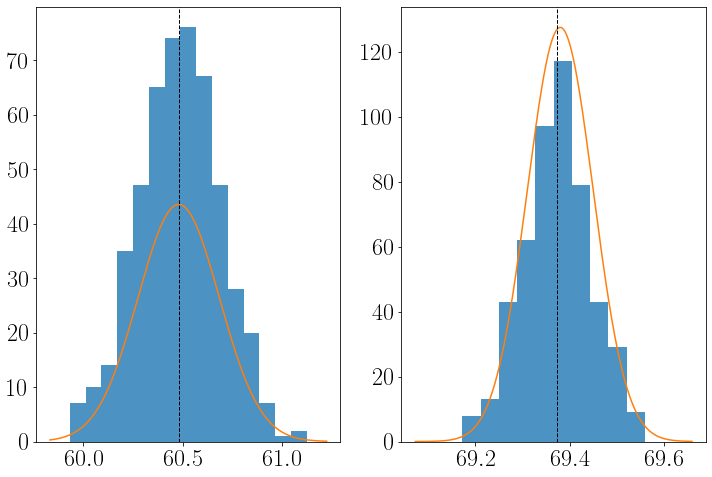

In [114]:
def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a
mu1 = dTamb_in
mu2 = dLaki_in

sig1 = CoreSpecs['lenTambCor']/400
sig2 = CoreSpecs['lenLakiCor']/500

xs1 = np.linspace(min(dTambs)-0.1, max(dTambs)+0.1, 1000)
xs2 = np.linspace(min(dLakis)-0.1, max(dLakis)+0.1, 1000)
gauss1 = func_gaussian(xs1, np.sqrt(500), mu1, sig1, 0)
gauss2 = func_gaussian(xs2, np.sqrt(500), mu2, sig2, 0)



fig, ax = plt.subplots(1,2,figsize=(12,8))

ax[0].hist(dTambs, alpha=0.8, bins=15)
ax[0].plot(xs1, gauss1)
ax[0].axvline(np.mean(dTambs), c='k', lw=1,ls='--')


ax[1].hist(dLakis, alpha=0.8, bins=10)
ax[1].plot(xs2, gauss2)
ax[1].axvline(np.mean(dLakis), c='k', lw=1,ls='--')

In [115]:
sigMin = 0.0
sigMax = 0.15

In [116]:
diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]
#diffLensUse[diffLensUse<0.04] = 0.047

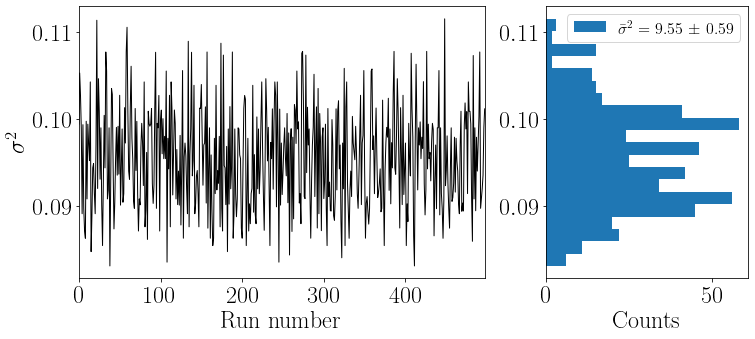

In [117]:
sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
x = np.arange(0,len(diffLensUse))

fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,5), sharey=False)

mpl.rcParams['font.size'] = 24

ax[0].plot(x,diffLensUse,c='k',lw=1)
ax[0].set(xlim=(min(x),max(x)), xlabel='Run number', ylabel='$\sigma^2$')
ax[1].hist(diffLensUse, bins=20, orientation="horizontal", label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f}');
ax[1].set(xlabel='Counts')
ax[1].legend(fontsize=16)

In [118]:
diffLens = diffLensUse
dTambs = dTambsUse
dLakis = dLakisUse

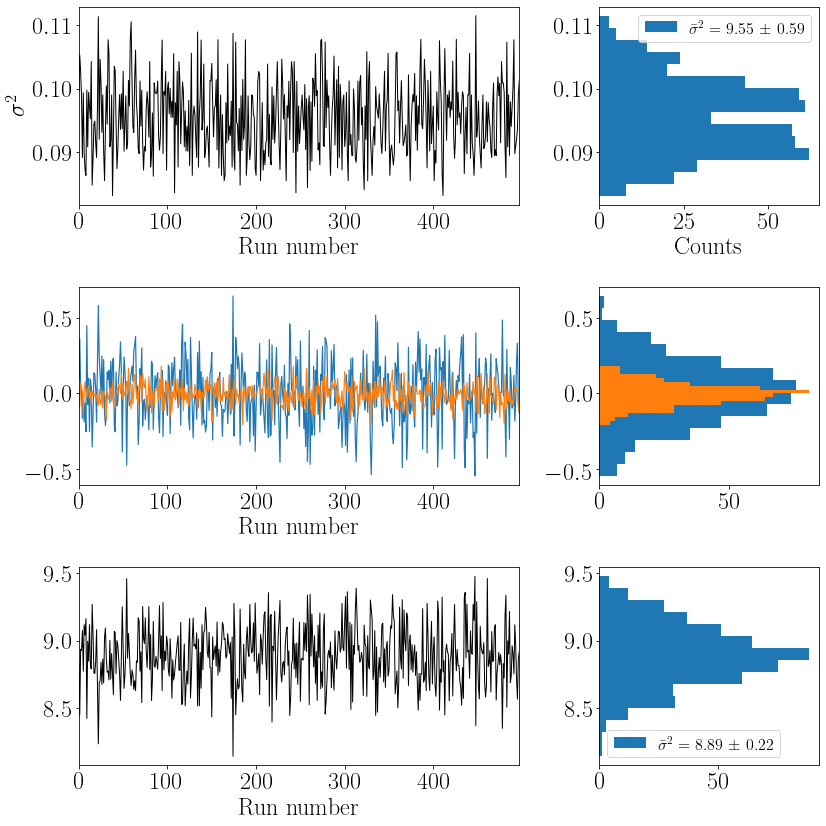

In [119]:
x = np.arange(0,len(diffLens))

sigmaMean = np.mean(diffLens)*100
sigmaSTD = np.std(diffLens)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(3,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,12), sharey=False)

mpl.rcParams['font.size'] = 24

ax[0,0].plot(x,diffLens,c='k',lw=1)
ax[0,0].set(xlim=(min(x),max(x)), xlabel='Run number', ylabel='$\sigma^2$')
ax[0,1].hist(diffLens, bins=15, orientation="horizontal", label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f}');
ax[0,1].set(xlabel='Counts')
ax[0,1].legend(fontsize=16)

ax[1,0].plot(x,dTambs-mu1,lw=1.2)
ax[1,0].set(xlim=(min(x),max(x)), xlabel='Run number')
ax[1,1].hist(dTambs-mu1, bins=15, orientation="horizontal");
ax[1,0].plot(x,dLakis-mu2,lw=1.2)
ax[1,0].set(xlim=(min(x),max(x)), xlabel='Run number')
ax[1,1].hist(dLakis-mu2, bins=15, orientation="horizontal");

ax[2,0].plot(x,dLakis-dTambs,c='k',lw=1)
ax[2,0].set(xlim=(min(x),max(x)), xlabel='Run number')
ax[2,1].hist(dLakis-dTambs, bins=15, orientation="horizontal", label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean_LT:.2f} $\pm$ {sigmaSTD_LT:.2f}')
ax[2,1].legend(fontsize=16)

fig.tight_layout()

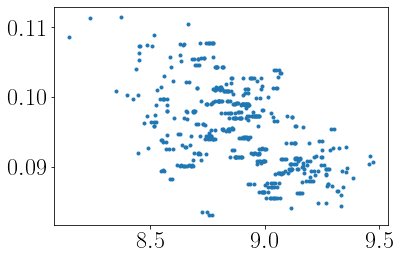

In [120]:
plt.plot(dLakis-dTambs, diffLens,'.')

In [121]:
from sigmaSolver import sigma_Solver

In [122]:
#diffLensUse = diffLens[diffLens>0.05]

In [123]:
def TempEst_analytical_arr(diffLens_in = np.array([0.08]), Accum_in = 0.3, rhoMeans_in = np.array([804.3])):
    diffLens = diffLens_in
    sigmaSolver_inst = sigma_Solver()
    T_intEst = np.zeros(len(diffLens))

    for i in range(len(diffLens)):
        T_est = sigmaSolver_inst.solveTemp(sigma_data = diffLens[i], accum = Accum_in, rho_CO = rhoMeans_in)
        T_intEst[i] = T_est
    return T_intEst

In [124]:
TsEst = TempEst_analytical_arr(diffLensUse, accum0)

In [125]:
Ts = TsEst - 273.15

In [126]:
x = np.arange(0,len(diffLensUse))

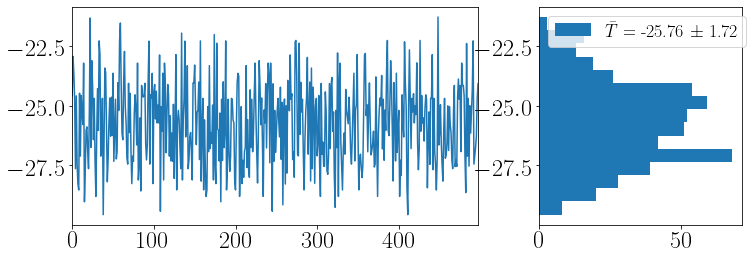

In [127]:
#fig,ax = plt.subplots(figsize=(8,6))
fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,4), sharey=False)

ax[0].plot(x, Ts)
ax[0].set(xlim=(min(x),max(x)))
ax[1].hist(Ts, bins=15, label=r'$\bar T$ = '+f'{np.mean(Ts):.2f} $\pm$ {np.std(Ts):.2f}', orientation='horizontal');
ax[1].legend(fontsize=18)

In [128]:

Temp0

-30.1